In [1]:
# Basics
import numpy as np
import pandas as pd
import re

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Transformation
from feature_engine.encoding import OrdinalEncoder
from feature_engine.discretisation import EqualWidthDiscretiser
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler

# Modelling
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## 2. Airbnb

### 2.1 Load and Explore the data

In [2]:
ab_df = pd.read_csv('listings.csv')
display(ab_df.head())
print(ab_df.shape)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,266763,Francesca,North Region,Woodlands,1.44255,103.79580,Private room,83,180,1,2013-10-21,0.01,2,365
1,50646,Pleasant Room along Bukit Timah,227796,Sujatha,Central Region,Bukit Timah,1.33235,103.78521,Private room,81,90,18,2014-12-26,0.28,1,365
2,56334,COZICOMFORT,266763,Francesca,North Region,Woodlands,1.44246,103.79667,Private room,69,6,20,2015-10-01,0.20,2,365
3,71609,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,East Region,Tampines,1.34541,103.95712,Private room,206,1,14,2019-08-11,0.15,9,353
4,71896,B&B Room 1 near Airport & EXPO,367042,Belinda,East Region,Tampines,1.34567,103.95963,Private room,94,1,22,2019-07-28,0.22,9,355


(7907, 16)


In [3]:
# Identifying numerical values and distribution
numeric = [c for c in ab_df.columns if ab_df[c].dtypes !='O']
display(ab_df[numeric].describe())

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,7.907000e+03,7.907000e+03,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,5149.000000,7907.000000,7907.000000
mean,2.338862e+07,9.114481e+07,1.314192,103.848787,169.332996,17.510054,12.807386,1.043669,40.607689,208.726318
std,1.016416e+07,8.190910e+07,0.030577,0.043675,340.187599,42.094616,29.707746,1.285851,65.135253,146.120034
min,4.909100e+04,2.366600e+04,1.243870,103.646560,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,1.582180e+07,2.305808e+07,1.295795,103.835825,65.000000,1.000000,0.000000,0.180000,2.000000,54.000000
50%,2.470627e+07,6.344891e+07,1.311030,103.849410,124.000000,3.000000,2.000000,0.550000,9.000000,260.000000
75%,3.234850e+07,1.553811e+08,1.322110,103.872535,199.000000,10.000000,10.000000,1.370000,48.000000,355.000000
max,3.811276e+07,2.885676e+08,1.454590,103.973420,10000.000000,1000.000000,323.000000,13.000000,274.000000,365.000000


In [4]:
# Viewing the diff values in the categorical columns
categorical = [c for c in ab_df.columns if ab_df[c].dtypes == 'O']
for cc in categorical:
    uv = ab_df[cc].unique()
    print(cc+": ")
    print(uv)

name: 
['COZICOMFORT LONG TERM STAY ROOM 2' 'Pleasant Room along Bukit Timah'
 'COZICOMFORT' ... '[ Farrer Park ] New City Fringe CBD Mins to MRT'
 'Cheap Master Room in Central of Singapore'
 'Amazing room with private bathroom walk to Orchard']
host_name: 
['Francesca' 'Sujatha' 'Belinda' ... 'Jolene' 'Ryokuka' 'Bo']
neighbourhood_group: 
['North Region' 'Central Region' 'East Region' 'West Region'
 'North-East Region']
neighbourhood: 
['Woodlands' 'Bukit Timah' 'Tampines' 'Bedok' 'Bukit Merah' 'Newton'
 'Geylang' 'River Valley' 'Jurong West' 'Rochor' 'Queenstown' 'Serangoon'
 'Marine Parade' 'Pasir Ris' 'Toa Payoh' 'Outram' 'Punggol' 'Tanglin'
 'Hougang' 'Kallang' 'Novena' 'Downtown Core' 'Bukit Panjang'
 'Singapore River' 'Orchard' 'Ang Mo Kio' 'Bukit Batok' 'Museum'
 'Sembawang' 'Choa Chu Kang' 'Central Water Catchment' 'Sengkang'
 'Clementi' 'Jurong East' 'Bishan' 'Yishun' 'Mandai' 'Southern Islands'
 'Sungei Kadut' 'Western Water Catchment' 'Tuas' 'Marina South'
 'Lim Chu Kang']

In [5]:
# Checking for null values
ab_df.isnull().sum()

id                                   0
name                                 2
host_id                              0
host_name                            0
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       2758
reviews_per_month                 2758
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [6]:
# Filling up missing values

ab_df['last_review'] = ab_df['last_review'].fillna(ab_df['last_review'].mode()[0])
ab_df['reviews_per_month'] = ab_df['reviews_per_month'].fillna(ab_df['reviews_per_month'].mean())
ab_df.isnull().sum()

id                                0
name                              2
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [7]:
#Choosing a subset of columns
ab_df2 = ab_df.drop(['name','id','host_id','latitude','longitude','last_review'], axis = 1)

In [8]:
ab_df2 = ab_df2[ab_df2["price"]>0]
ab_df2.isnull().sum()

host_name                         0
neighbourhood_group               0
neighbourhood                     0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [9]:
numeric2 = [c for c in ab_df2.columns if ab_df2[c].dtypes !='O']
display(ab_df2[numeric2].describe())

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,7906.000000,7906.000000,7906.000000,7906.000000,7906.000000,7906.000000
mean,169.354414,17.511890,12.807867,1.043736,40.612067,208.708323
std,340.203784,42.096963,29.709594,1.037652,65.138210,146.120514
min,14.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,65.000000,1.000000,0.000000,0.330000,2.000000,54.000000
50%,124.000000,3.000000,2.000000,1.043669,9.000000,260.000000
75%,199.000000,10.000000,10.000000,1.043669,48.000000,355.000000
max,10000.000000,1000.000000,323.000000,13.000000,274.000000,365.000000


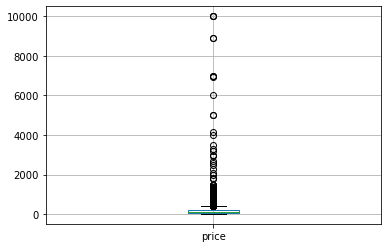

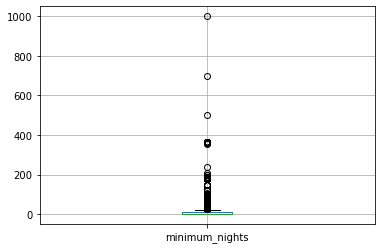

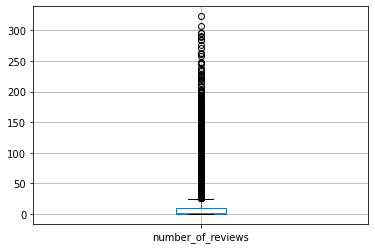

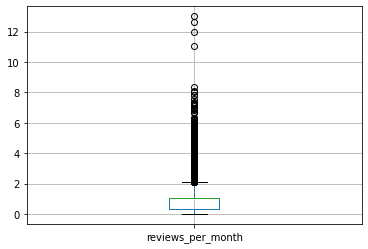

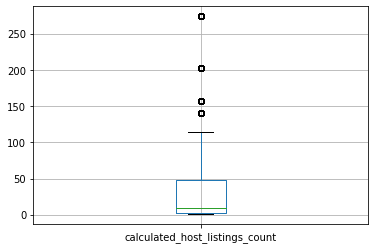

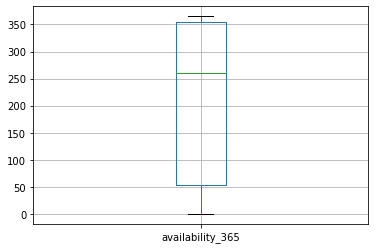

In [10]:
for numcol in numeric2:
    ab_df2.boxplot(numcol)
    plt.show()

In [11]:
ab_df2[ab_df2['price'] >= 6000]

,host_name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
1319,Yin,Central Region,Outram,Private room,7000,2,5,0.180000,1,365
2100,Darren,Central Region,Southern Islands,Entire home/apt,8900,2,0,1.043669,6,361
2392,Yolivia,West Region,Bukit Panjang,Private room,10000,1,1,0.040000,1,0
2764,X-Roy,West Region,Jurong East,Private room,7000,2,0,1.043669,1,0
2978,Jj,West Region,Tuas,Entire home/apt,10000,2,5,0.210000,1,89
3485,Darren,Central Region,Southern Islands,Entire home/apt,8900,2,0,1.043669,6,0
4399,Jo,Central Region,Kallang,Private room,6000,1,0,1.043669,1,0
5823,David,Central Region,Kallang,Private room,10000,1,0,1.043669,1,0
7485,Lily,West Region,Bukit Batok,Entire home/apt,6944,1,0,1.043669,1,179


In [12]:
ab_df2.shape

(7906, 10)

In [13]:
ab_df2 = ab_df2[ab_df2.price != 10000]

In [14]:
ab_df2.shape

(7903, 10)

In [15]:
from feature_engine.outliers import Winsorizer
windsorizer = Winsorizer(capping_method ='iqr', tail='right', fold =3, variables=['price'])
windsorizer.fit(ab_df2)
ab_df2 = windsorizer.transform(ab_df2)

In [16]:
ab_df2['price'].describe()

count    7903.000000
mean      151.708339
std       116.551182
min        14.000000
25%        65.000000
50%       124.000000
75%       199.000000
max       601.000000
Name: price, dtype: float64

In [17]:
catcol = [c for c in ab_df2.columns if ab_df2[c].dtypes == 'O']
print(catcol)

['host_name', 'neighbourhood_group', 'neighbourhood', 'room_type']


In [18]:
ab_df2.columns

Index(['host_name', 'neighbourhood_group', 'neighbourhood', 'room_type',
       'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

In [19]:
from feature_engine.encoding import OneHotEncoder
ohe_enc = OneHotEncoder(                                      
    top_categories=5, variables=['host_name','neighbourhood'], drop_last=False)
ohe_enc.fit(ab_df2)
ab_df2 = ohe_enc.transform(ab_df2)
display(ab_df2.head())

,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,host_name_Jay,host_name_Alvin,host_name_Richards,host_name_Aaron,host_name_Rain,neighbourhood_Kallang,neighbourhood_Geylang,neighbourhood_Novena,neighbourhood_Rochor,neighbourhood_Outram
0,North Region,Private room,83.0,180,1,0.01,2,365,0,0,0,0,0,0,0,0,0,0
1,Central Region,Private room,81.0,90,18,0.28,1,365,0,0,0,0,0,0,0,0,0,0
2,North Region,Private room,69.0,6,20,0.20,2,365,0,0,0,0,0,0,0,0,0,0
3,East Region,Private room,206.0,1,14,0.15,9,353,0,0,0,0,0,0,0,0,0,0
4,East Region,Private room,94.0,1,22,0.22,9,355,0,0,0,0,0,0,0,0,0,0


In [20]:
ab_df2.columns

Index(['neighbourhood_group', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'host_name_Jay',
       'host_name_Alvin', 'host_name_Richards', 'host_name_Aaron',
       'host_name_Rain', 'neighbourhood_Kallang', 'neighbourhood_Geylang',
       'neighbourhood_Novena', 'neighbourhood_Rochor', 'neighbourhood_Outram'],
      dtype='object')

In [21]:
ab_df2['room_type'].value_counts()
roomType_mapping = {"Entire home/apt" : 1, "Private room" : 2, "Shared room" : 3}
ab_df2['room_type'] = ab_df2['room_type'].map(roomType_mapping).astype(int)
ab_df2.head()

,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,host_name_Jay,host_name_Alvin,host_name_Richards,host_name_Aaron,host_name_Rain,neighbourhood_Kallang,neighbourhood_Geylang,neighbourhood_Novena,neighbourhood_Rochor,neighbourhood_Outram
0,North Region,2,83.0,180,1,0.01,2,365,0,0,0,0,0,0,0,0,0,0
1,Central Region,2,81.0,90,18,0.28,1,365,0,0,0,0,0,0,0,0,0,0
2,North Region,2,69.0,6,20,0.20,2,365,0,0,0,0,0,0,0,0,0,0
3,East Region,2,206.0,1,14,0.15,9,353,0,0,0,0,0,0,0,0,0,0
4,East Region,2,94.0,1,22,0.22,9,355,0,0,0,0,0,0,0,0,0,0


oe = OrdinalEncoder(
    encoding_method='arbitrary',
    variables= ['neighbourhood_group'])
oe.fit(ab_df2)
print(oe.encoder_dict_)

ab_df_enc = oe.transform(ab_df2)
display(ab_df_enc.head())

In [22]:
ab_df2 = ab_df2[ab_df2['neighbourhood_group'] == 'Central Region']
ab_df_enc = ab_df2.drop(['neighbourhood_group'], axis = 1)

In [23]:
catcol2 = [c for c in ab_df_enc.columns if ab_df_enc[c].dtypes == 'O']
print(catcol2)

[]


In [24]:
ab_df_enc.describe()

,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,host_name_Jay,host_name_Alvin,host_name_Richards,host_name_Aaron,host_name_Rain,neighbourhood_Kallang,neighbourhood_Geylang,neighbourhood_Novena,neighbourhood_Rochor,neighbourhood_Outram
count,6307.000000,6307.000000,6307.000000,6307.000000,6307.000000,6307.000000,6307.000000,6307.000000,6307.000000,6307.000000,6307.000000,6307.000000,6307.000000,6307.000000,6307.000000,6307.000000,6307.000000
mean,1.462661,162.224354,15.347075,13.040431,1.067036,47.318059,215.448391,0.039321,0.039163,0.024734,0.022673,0.017599,0.165213,0.157603,0.085143,0.084826,0.075630
std,0.599180,117.927046,36.052058,29.317446,1.042744,67.696251,143.580731,0.194374,0.193998,0.155327,0.148871,0.131501,0.371402,0.364397,0.279117,0.278645,0.264427
min,1.000000,14.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,81.000000,2.000000,0.000000,0.360000,3.000000,63.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,135.000000,3.000000,2.000000,1.043669,14.000000,269.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,208.000000,10.000000,11.000000,1.043669,67.000000,355.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,601.000000,1000.000000,307.000000,13.000000,274.000000,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
mms = MinMaxScaler()
ab_df_enc[['minimum_nights','number_of_reviews','calculated_host_listings_count','availability_365']] = mms.fit_transform(ab_df_enc[['minimum_nights','number_of_reviews','calculated_host_listings_count','availability_365']])

In [26]:
ab_df_enc.describe()

,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,host_name_Jay,host_name_Alvin,host_name_Richards,host_name_Aaron,host_name_Rain,neighbourhood_Kallang,neighbourhood_Geylang,neighbourhood_Novena,neighbourhood_Rochor,neighbourhood_Outram
count,6307.000000,6307.000000,6307.000000,6307.000000,6307.000000,6307.000000,6307.000000,6307.000000,6307.000000,6307.000000,6307.000000,6307.000000,6307.000000,6307.000000,6307.000000,6307.000000,6307.000000
mean,1.462661,162.224354,0.014361,0.042477,1.067036,0.169663,0.590270,0.039321,0.039163,0.024734,0.022673,0.017599,0.165213,0.157603,0.085143,0.084826,0.075630
std,0.599180,117.927046,0.036088,0.095497,1.042744,0.247972,0.393372,0.194374,0.193998,0.155327,0.148871,0.131501,0.371402,0.364397,0.279117,0.278645,0.264427
min,1.000000,14.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,81.000000,0.001001,0.000000,0.360000,0.007326,0.172603,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,135.000000,0.002002,0.006515,1.043669,0.047619,0.736986,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,208.000000,0.009009,0.035831,1.043669,0.241758,0.972603,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,601.000000,1.000000,1.000000,13.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
X_ab = ab_df_enc.drop(['price'], axis =1)
y_ab = ab_df_enc["price"]
X_train_ab, X_test_ab, y_train_ab, y_test_ab = train_test_split(X_ab, y_ab, test_size=0.3, random_state=10)
print(X_train_ab.shape, X_test_ab.shape, y_train_ab.shape, y_test_ab.shape)

lm = LinearRegression()
# Fitting of model
lm.fit(X_train_ab, y_train_ab)

y_fitted_ab = lm.predict(X_train_ab)

# RMSE and R^2 for training set
print(sqrt(mean_squared_error(y_fitted_ab, y_train_ab)), '(Train RMSE)') 
print(lm.score(X_train_ab, y_train_ab), '(Train R^2 Value)') 

y_pred_ab = lm.predict(X_test_ab)

# RMSE and R^2 for testing set
print()
print(sqrt(mean_squared_error(y_pred_ab, y_test_ab)), '(Test RMSE)') 
print(lm.score(X_test_ab, y_test_ab), '(Test R^2 Value)') 

(4414, 16) (1893, 16) (4414,) (1893,)
98.40643536144904 (Train RMSE)
0.3019656698821921 (Train R^2 Value)

99.59572205804295 (Test RMSE)
0.2903743595154993 (Test R^2 Value)


In [28]:
ab_df_enc.to_csv('listings_new.csv')